In [1]:
# import os
import pathlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from IPython import display


In [2]:
# Utility functions for loading audio files and making sure the sample rate is correct.

def load_wav_16k_mono(filename):
    """ Load a WAV file, convert it to a float tensor, resample to 16 kHz single-channel audio. """
    file_contents = tf.io.read_file(filename)
    wav, sample_rate = tf.audio.decode_wav(
          file_contents,
          desired_channels=1)
    wav = tf.squeeze(wav, axis=-1)
    return wav

In [3]:
def get_spectrogram(waveform):
  # Zero-padding for an audio waveform with less than 16,000 samples.
  input_len = 16000
  waveform = waveform[:input_len]
  zero_padding = tf.zeros(
      [16000] - tf.shape(waveform),
      dtype=tf.float32)
  
  # Cast the waveform tensors' dtype to float32.
  waveform = tf.cast(waveform, dtype=tf.float32)

  # Concatenate the waveform with `zero_padding`, which ensures all audio
  # clips are of the same length.

  equal_length = tf.concat([waveform, zero_padding], 0)

  # Convert the waveform to a spectrogram via a STFT.
  spectrogram = tf.signal.stft(
      equal_length, frame_length=255, frame_step=128)
  
  # Obtain the magnitude of the STFT.
  spectrogram = tf.abs(spectrogram)
  
  # Add a `channels` dimension, so that the spectrogram can be used
  # as image-like input data with convolution layers (which expect
  # shape (`batch_size`, `height`, `width`, `channels`).
  spectrogram = spectrogram[..., tf.newaxis]
  return spectrogram

In [4]:
def plot_spectrogram(spectrogram, ax):
  if len(spectrogram.shape) > 2:
    assert len(spectrogram.shape) == 3
    spectrogram = np.squeeze(spectrogram, axis=-1)
    
  # Convert the frequencies to log scale and transpose, so that the time is
  # represented on the x-axis (columns).
  # Add an epsilon to avoid taking a log of zero.
  log_spec = np.log(spectrogram.T + np.finfo(float).eps)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)

Preporocessing Audio to Create a Spectogram as input to the model.

In [5]:
SAMPLE_PATH = 'data/TestRecordings/recording.wav'

waveform = load_wav_16k_mono(SAMPLE_PATH)
display.display(display.Audio(waveform, rate=16000))
spectrogram = get_spectrogram(waveform)

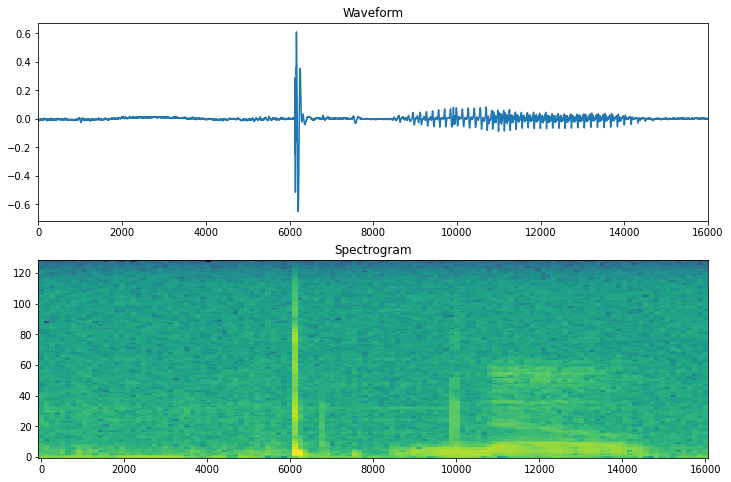

In [6]:
fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16000])
#axes[0].set_ylim([-.1,.1])

plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.show()

Load The tflite Model

In [10]:

tflite_interpreter = tf.lite.Interpreter(model_path = 'conv_actions_frozen.tflite')
tflite_interpreter.allocate_tensors()
input_details = tflite_interpreter.get_input_details()
output_details = tflite_interpreter.get_output_details()

In [11]:
input_shape = input_details[0]['shape']
input_tensor= np.array(np.expand_dims(spectrogram,0), dtype=np.float32)

In [12]:
input_index = tflite_interpreter.get_input_details()[0]["index"]
tflite_interpreter.set_tensor(input_index, input_tensor)

In [13]:
#Run the inference
tflite_interpreter.invoke()
output_details = tflite_interpreter.get_output_details()

In [14]:
output_data = tflite_interpreter.get_tensor(output_details[0]['index'])
results = np.squeeze(output_data)

In [15]:
commands = np.array(['up', 'go' ,'no', 'right', 'left' ,'down', 'stop', 'yes'])
print(output_data)

[[-1.173436   -1.2693949  -2.3049107   0.63119966  0.73832285 -1.0239305
   2.4786472  -1.3467689 ]]


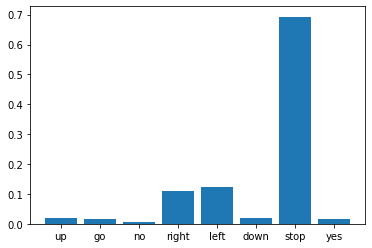

In [16]:
plt.bar(commands, tf.nn.softmax(results))
plt.show()